In [1]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
import pandas as pd
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PoissonRegressor
import numpy as np

import matplotlib.pyplot as plt


In [10]:
X,y = fetch_openml(data_id=43927,return_X_y=True,as_frame=True)

X['date']=pd.to_datetime(X['year'].astype(int).astype(str)+"-"+
               X['month'].astype(int).astype(str)+"-"+
               X['day'].astype(int).astype(str)
               )

X['price'] = y


c:\Users\Jason\Desktop\git_control\ml-research\.venv\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


# Multi-Target Regressions for Proportioning Mathematically Limit Predictions

Consider a regression task with K targets (rather than a typical single-target regression), where each target is a percentage allocated to a single entity, and all of the target proportions sum to 1. Linear-algebraically, nothing about this regression is different from single-target regression, and the coefficients can be solved explicitly:

$ B = (X^{t} \cdot X)^{-1} \cdot (X^{t} \cdot Y) $

If input matrix X has M predictors (I always include the intercept in M), with K targets, B is a matrix of shape MxK.

Consider the condition that targets in Y sum to 1 (over axis 1). This is a dot product of Y with a vector of ones, size K. The condition that Y sums to 1 can be written as:

$ Y \cdot 1 = Y_{sum} = 1$

$ Y \cdot 1 = Y_{sum}$ has no variance, it is a constant, and so a regression for $ Y_{sum} $ would return a non-zero intercept ($ b_0 = 1$). Feature coefficients would be equal to 0 because the features have no correlation with the target (because the target has no variance). 

The multiplication of a Kx1 vector of ones onto Y in order to sum over Y can be symetrically applied to the other side of the regression, and in doing so, B of shape MxK is consolidated by summation into shape Mx1:

$ Y = X \cdot B + Norm(0,\sigma, (N,K))$

$ Y \cdot 1 = Y_{sum} = X \cdot B \cdot 1 + Norm(0,\sigma, (N,K)) \cdot 1$

$ Y_{sum} = X \cdot B_{sum} + Norm(0,\sigma)$

Here, $ B_{sum} $ is the vector of coefficients that would be calculated from a regression against $ Y_{sum} $, which has a constant value of 1, or no variance. So, while all of the feature coefficients in $ B $ sum over axis 1 to equal 0, the intercept coefficients in $ B $ sum to 1. 








$\sum{ \hat{X} \cdot ( (X^t\cdot X)^{-1}\cdot (X^{t} \cdot Y) ) } = \sum{ Y }$

In [11]:
X.groupby(['region'])['Total Volume'].sum().sort_values()

region
Syracuse               1.094267e+07
Boise                  1.441319e+07
Spokane                1.556528e+07
Albany                 1.606780e+07
Louisville             1.609700e+07
Pittsburgh             1.880635e+07
BuffaloRochester       2.296247e+07
Roanoke                2.504201e+07
Jacksonville           2.879000e+07
Columbus               2.999336e+07
GrandRapids            3.021174e+07
Indianapolis           3.026339e+07
StLouis                3.207283e+07
Charlotte              3.555554e+07
Nashville              3.561209e+07
HarrisburgScranton     4.180886e+07
RichmondNorfolk        4.223085e+07
CincinnatiDayton       4.452201e+07
NewOrleansMobile       4.569514e+07
RaleighGreensboro      4.820273e+07
HartfordSpringfield    5.067054e+07
LasVegas               5.437691e+07
Orlando                5.866070e+07
SouthCarolina          6.075377e+07
Detroit                6.342242e+07
Tampa                  6.600454e+07
NorthernNewEngland     7.153289e+07
Philadelphia         

In [12]:
mask = (X['region']=='TotalUS')#&(X['type']=='conventional')

In [13]:
d1 = X[mask].groupby(['date','type']).agg({'Total Volume':'sum',
                                           'price':'sum'}).reset_index()
d2 = pd.crosstab(
    index = d1.date,
    columns = d1.type,
    values = d1['Total Volume'],
    aggfunc='sum'
)
p2 = pd.crosstab(
    index = d1.date,
    columns = d1.type,
    values = d1['price'],
    aggfunc='sum'
)




In [14]:
p2.columns = ['c_price','o_price']

In [15]:
ratios = d2.copy()
ratios['conventional'] = d2.conventional/(d2.conventional+d2.organic)
ratios['organic'] = d2.organic/(d2.conventional+d2.organic)

In [16]:
ratios

type,conventional,organic
date,,
2015-01-04,0.980809,0.019191
2015-01-11,0.977482,0.022518
2015-01-18,0.976035,0.023965
2015-01-25,0.980833,0.019167
2015-02-01,0.983679,0.016321
...,...,...
2018-02-25,0.964807,0.035193
2018-03-04,0.961430,0.038570
2018-03-11,0.960482,0.039518


In [36]:
Xt = p2.copy()
Xt['int'] = 1

yt = ratios.copy()

In [37]:
coefs = np.linalg.pinv(Xt.T@Xt)@(Xt.T@yt)

In [71]:
print('coefs: \n',np.array(coefs))
print('coef summations: \n',np.array(coefs).sum(axis=1))
print("Feature coefficients sum over axis 1 to equal 0, and the intercepts sum to 1.")

coefs: 
 [[-0.03627305  0.03627305]
 [ 0.00943814 -0.00943814]
 [ 0.99702661  0.00297339]]
coef summations: 
 [ 1.61676228e-15 -1.31266525e-14  1.00000000e+00]
Feature coefficients sum over axis 1 to equal 0, and the intercepts sum to 1.


In [42]:
preds = Xt@np.array(coefs)

In [59]:
norm = preds.sum(axis=1)

preds = preds.divide(norm,axis=0)

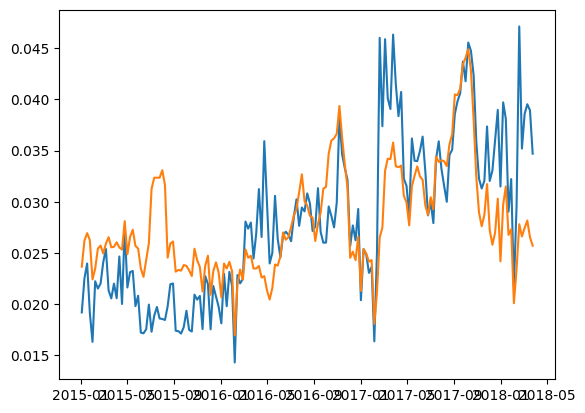

In [60]:
plt.plot(ratios['organic'])
plt.plot(preds[1])

In [63]:
pd.DataFrame([[3,3,1]])@coefs

type,conventional,organic
0,0.916522,0.083478


In [66]:
(pd.DataFrame([[3,3,1]])@coefs).sum(axis=1)

0    1.0
dtype: float64